In [1]:
from astropy.table import Table
from matplotlib import pyplot as plt
import numpy as np
import random
from lightcurve_fitting.lightcurve import LC
from dust_extinction.parameter_averages import G23
from astropy import units as u
from scipy.stats import wasserstein_distance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, PairwiseKernel
from scipy.optimize import minimize
import speclite.filters
from astropy import units as u
from astropy.io import ascii

In [2]:
meta_data = Table.read('plasticc_train_metadata.csv',format='ascii')
lc_data = Table.read('plasticc_train_lightcurves.csv',format='ascii')

lsst_filters = dict(u=3740, g=4870, r=6250, i=7700, z=8900, y=10845)

transient_class = dict(SNIa=90,SNIa91bg=67,SNIax=52,SNII=42,SNIbc=62,SLSNI=95,TDE=15,KN=64,AGN=88,
                       ILOT=992,CaRT=993,PISN=994)
ids = [row['object_id'] for row in meta_data if int(row['target']) in np.fromiter(transient_class.values(), dtype=int)]
clas = [row['true_target'] for row in meta_data if int(row['target']) in np.fromiter(transient_class.values(), dtype=int)]

In [549]:
len(ids)

5523

In [3]:
# calculate the flux corresponding to the limiting magnitude
zpt = 27.5
m_lim = 26
lim_flux = 10**((m_lim-zpt)/-2.5)

# convert flux according to 
lc_data['flux'] = [row['flux'] if row['detected_bool'] == 1 else lim_flux for row in lc_data]
lc_data['flux'] = [flux if flux > lim_flux else lim_flux for flux in lc_data['flux']]

# calculate apparent magnitudes
lc_data['mag'] = -2.5 * np.log10(lc_data['flux']) + 27.5

In [4]:
def cal_absmag(table, dm, photo_z,mwebv):
    ext = G23(Rv=3.1)
    reddening = -2.5 * np.log10(ext.extinguish(np.fromiter(lsst_filters.values(), dtype=float) * u.AA, Ebv=mwebv))
    lim_mag = 26 - dm + 2.5*np.log10(1+photo_z) - reddening
    absmag = [row['mag'] - dm + 2.5*np.log10(1+photo_z) - reddening[row['passband']] - lim_mag[row['passband']] for row in table]
    return absmag

In [5]:
lsst = speclite.filters.load_filters(f'lsst2016-*')

filters = 'ugrizy'
colors = ['darkblue','green','red','orange','purple','black']
max_band = len(filters)

data = {f: speclite.filters.load_filters(f'lsst2016-{f}')[0] for f in filters}
wavelength = np.linspace(3000, 11000, num=10000)*u.AA

normalized = {f: data[f](wavelength)/data[f](wavelength).sum() for f in filters}

def distance_between_filters(filter1, filter2):
    return wasserstein_distance(u_values=wavelength.value, v_values=wavelength.value,
                                u_weights=normalized[filter1], v_weights=normalized[filter2])

distance_matrix = np.array([[distance_between_filters(col, row) for col in filters] for row in filters])
distance_matrix /= np.average(distance_matrix)

In [492]:
def run_gp(Xt, Xf, Xfl, Xfle):

    mag_var = np.var(Xfl)

    def metric(x1, x2, p):
        band1 = (x1[1].astype(int))
        band2 = (x2[1].astype(int))
        time_distance = x2[0] - x1[0]
        photometric_distance = distance_matrix[band1, band2]

        return (
            mag_var*np.exp(-photometric_distance**2/(2*p[0]**2) - time_distance**2/(2*p[1]**2))
            )
        
    def fit_gp(X, y, p):
        cur_metric = lambda x1, x2, gamma: metric(x1, x2, p)

        kernel = PairwiseKernel(metric=cur_metric)
        gp = GaussianProcessRegressor(kernel=kernel,
                                    alpha=y[:, 1]**2,
                                    normalize_y=False)
        gp.fit(X, y[:, 0])
        return gp

    cX = np.stack(
        (Xt, Xf), axis=1).astype(np.float32)
    cy = np.stack(
        (Xfl, Xfle), axis=1).astype(np.float32)

    def try_lt_lp(p):
        summed_log_like = 0.0
        gp = fit_gp(cX, cy, p)
        summed_log_like += gp.log_marginal_likelihood()

        return -summed_log_like
    
    
    res = minimize(
        lambda x: try_lt_lp(np.exp(x)),
        [0.0, 0.0], bounds=[(0, 6),(0,np.diff(Xt).max())])
    best_lengths = np.exp(
        res.x
    )

    gp = fit_gp(cX, cy, best_lengths)
    all_mus = []
    all_stds = []
    for band in range(max_band):
        times = np.linspace(Xt.min(),Xt.max(),100)
        test_data = np.array([[it, band] for it in times])
        mu, std = gp.predict(test_data, return_std=True)
        all_mus.append(mu)
        all_stds.append(std**2) #this is var, hacky
    
    all_stds = np.array(all_stds)
    all_mus = np.array(all_mus)
    return all_mus, all_stds, gp

In [380]:
def make_dense_LC(table, nfilts=6):
    pred, pred_var, gp = run_gp(table['phase'], table['passband'], table['absmag'], table['magerr'])
    pred = pred.T
    pred_var = pred_var.T

    dense_fluxes = pred 
    dense_errs = np.sqrt(pred_var)
    return dense_fluxes, dense_errs

In [374]:
def process_data(idd, min_d=-100, max_d=200):
    pre_lc = lc_data[lc_data['object_id']==idd]
    photo_z = float(meta_data[meta_data['object_id']==idd]['hostgal_photoz'])
    peak_d = float(pre_lc[np.argmin(pre_lc['mag'])]['mjd'])
    dm = float(meta_data[meta_data['object_id']==idd]['true_distmod'])
    mwebv = float(meta_data[meta_data['object_id']==idd]['mwebv'])
    
    pre_lc['absmag'] = cal_absmag(pre_lc, dm, photo_z,mwebv)
    pre_lc['phase'] = (pre_lc['mjd'] - peak_d)/(1+photo_z)
    pre_lc['magerr'] = (2.5/np.log(10))*(pre_lc['flux_err']/pre_lc['flux'])
    cut_inds = np.where((pre_lc['phase'] >= min_d) &(pre_lc['phase'] <= max_d))
    lc = pre_lc[['phase', 'passband','mag','absmag','magerr']][cut_inds]
    return lc[lc['absmag']<0]

In [287]:
np.diff(lc['phase']).max()

8.246982908963275

In [59]:
labels = np.vstack((ids,clas)).T

In [477]:
k=0

In [535]:
k += 1

In [536]:
inds = np.where(labels[:,1]==np.fromiter(transient_class.values(), dtype=int)[k])
print(np.fromiter(transient_class.values(), dtype=int)[k])

15


In [541]:
import random
idd = random.sample(sorted(labels[inds][:,0]),1)
# cls = row['true_target']
lc = process_data(idd)

dense_fluxes, dense_errs = make_dense_LC(lc, nfilts=6)

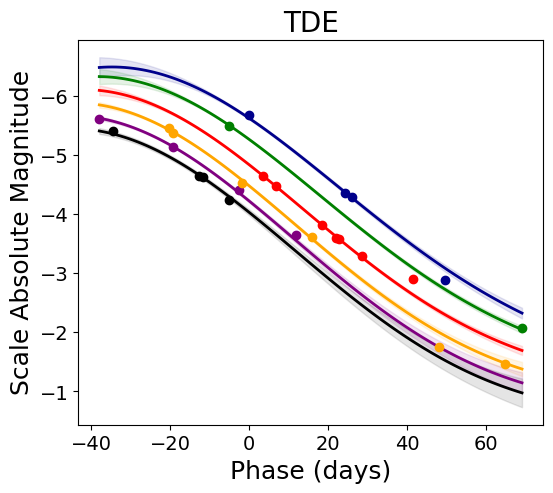

In [542]:
fig = plt.figure(figsize=(6,5))

colors = ['darkblue','green','red','orange','purple','black']
times = np.linspace(lc['phase'].min(),lc['phase'].max(),100)
for i in range(6):
    plt.plot(times,dense_fluxes[:,i],color=colors[i],lw=2)
    plt.fill_between(times, dense_fluxes[:,i]+dense_errs[:,i],
                     dense_fluxes[:,i]-dense_errs[:,i],alpha=0.1,color=colors[i])
for row in lc:
    plt.plot(row['phase'],row['absmag'],'o',color=colors[row['passband']])

plt.gca().invert_yaxis()
plt.tick_params(labelsize=14)
plt.xlabel('Phase (days)', fontsize=18)
plt.ylabel('Scale Absolute Magnitude', fontsize=18)
plt.title(list(transient_class.keys())[k], fontsize=20)
plt.savefig('/Users/brianhsu/Downloads/'+list(transient_class.keys())[k]+'.png',bbox_inches='tight')

In [ ]:
dir_ = '/Users/brianhsu/ASTR513/ASTR513-Term-Project/preprocessed_lc/'
for idd, cls in zip(ids, clas):
    lc = process_data(idd)
    
    dense_fluxes, dense_errs = make_dense_LC(lc, nfilts=6)
    
    gp_table = Table()
    times = np.round(np.linspace(lc['phase'].min(),lc['phase'].max(),100),2)
    gp_table['times'] = times
    filt_ind = dict(u=0, g=1, r=2, i=3, z=4, y=5)
    for band, ind in filt_ind.items():
        gp_table[band] = np.round(dense_fluxes.T[ind],2)
        gp_table[band+'_err'] = np.round(dense_errs.T[ind],2)
    ascii.write(gp_table, dir_+'id'+str(idd)+'c'+str(cls)+'.dat', overwrite=True)

In [ ]:
from glob import glob
glob('/Users/brianhsu/ASTR513/ASTR513-Term-Project/preprocessed_lc/*')[2050]

In [ ]:
def parse_filename(filename):
    obj = filename.split('/')[-1]
    idd = int(obj.split('c')[0][2:])
    cls = int(obj.split('c')[-1][:-4])
    return idd, cls

In [ ]:
import random
filename = random.sample(glob('/Users/brianhsu/ASTR513/ASTR513-Term-Project/preprocessed_lc/*c95*'),k=1)[0]
idd, cls = parse_filename(filename)
print(idd, cls)

In [ ]:
lc = process_data(idd)

In [ ]:
dat = np.genfromtxt(filename,skip_header=True, unpack=True, dtype=float)

In [ ]:
fig = plt.figure(figsize=(6,5))

colors = ['darkblue','green','red','orange','purple','black']
times = np.linspace(lc['phase'].min(),lc['phase'].max(),300)
for j, i in enumerate(np.arange(1,13,2)):
    plt.plot(dat[0],dat[i],color=colors[j])
#     plt.fill_between(times, dense_fluxes[:,i]+dense_errs[:,i],
#                      dense_fluxes[:,i]-dense_errs[:,i],alpha=0.2,color=colors[i])
# plt.plot(times,np.round(dense_fluxes.T[0],2),color=colors[0])
# plt.fill_between(times, dense_fluxes.T[0]+dense_errs.T[0],
#                      dense_fluxes.T[0]-dense_errs.T[0],alpha=0.2,color=colors[0])
for row in lc:
    plt.plot(row['phase'],row['absmag'],'o',color=colors[row['passband']])

plt.gca().invert_yaxis()
plt.show()

In [3]:
import numpy as np
test = np.load('products/encodings/en.npz', allow_pickle=True)

In [5]:
test['lcs']

KeyError: 'lcs is not a file in the archive'